In [34]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [35]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [36]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [37]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [38]:
# reflect an existing datadb into a new model
db=automap_base()
db.prepare(engine, reflect=True)
# reflect the tables

In [7]:
# View all of the classes that automap found
db.classes.keys()

['measurement', 'station']

In [40]:
# Save references to each table
station = db.classes.station
measurement = db.classes.measurement

In [41]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [42]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [43]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
df = calc_temps('2017-08-01', '2017-08-07')
df

[(72.0, 79.25, 83.0)]

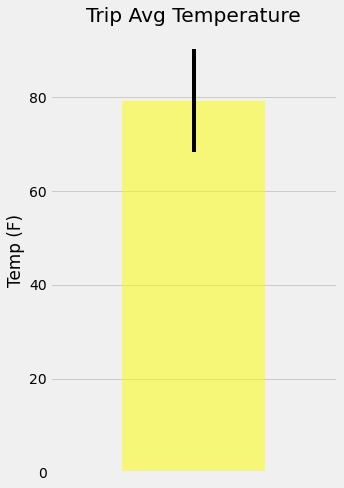

In [44]:
# Plot the results from your previous query as a bar chart. 
df = pd.DataFrame(df, columns=["TMIN", "TAVG", "TMAX"])
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df.plot.bar(y="TAVG", yerr=(df["TMAX"] - df["TMIN"]), 
                    title="Trip Avg Temperature", color="yellow", 
                    alpha=0.5, figsize=(5,7), legend=None)
plt.xticks([])
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.savefig("Images/temperature.png")
plt.show()

### Daily Rainfall Average

In [45]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
rainfall_all_stations = (session.query(measurement.station,station.name,func.sum(measurement.prcp),station.latitude,station.longitude,station.elevation).filter(measurement.date >= '2017-08-01').filter(measurement.date <= '2017-08-07').filter(measurement.station == station.station).group_by(measurement.station).order_by(func.sum(measurement.prcp).desc()).all())
rainfall_all_stations

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  0.36,
  21.3331,
  -157.8025,
  152.4),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  0.22,
  21.5213,
  -157.8374,
  7.0),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  0.06,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 0.04, 21.2716, -157.8168, 3.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  0.0,
  21.33556,
  -157.71139,
  19.5)]

In [46]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
df = pd.DataFrame(rainfall_all_stations, columns = ["Station ID","Station Name","Total Precipitation", "Latitude","Longitude","Elevation"])
df

,Station ID,Station Name,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.36,21.33310,-157.80250,152.4
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.22,21.52130,-157.83740,7.0
2,USC00519281,"WAIHEE 837.5, HI US",0.06,21.45167,-157.84889,32.9
3,USC00519397,"WAIKIKI 717.2, HI US",0.04,21.27160,-157.81680,3.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.00,21.33556,-157.71139,19.5


### Daily Temperature Normals

In [48]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [50]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
dates = session.query(measurement.date).filter(measurement.date >= start_date).filter(measurement.date <= end_date).group_by(measurement.date).all()
vacation_dates = [x[0] for x in dates]
vacation_dates

['2017-08-01',
 '2017-08-02',
 '2017-08-03',
 '2017-08-04',
 '2017-08-05',
 '2017-08-06',
 '2017-08-07']

In [52]:
# Strip off the year and save a list of strings in the format %m-%d
striped_year = [x[5:] for x in vacation_dates]
striped_year

['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']

In [53]:
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for i in striped_year:
    normals.append(daily_normals(i)[0])

normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [58]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=["TMIN", "TAVG", "TMAX"])
df["Date"] = vacation_dates
df.set_index("Date", inplace=True)
df

,TMIN,TAVG,TMAX
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


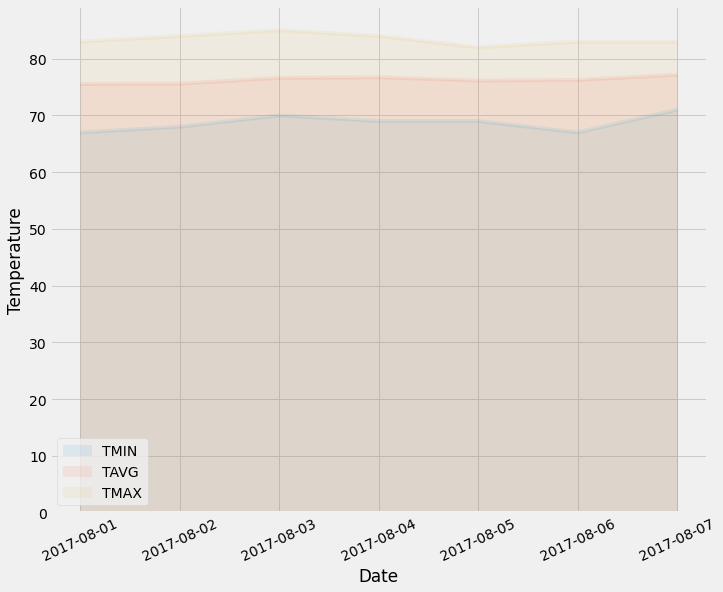

In [64]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', alpha=.09, stacked=False, x_compat=True, figsize=(10,8))
plt.tight_layout()
plt.legend(loc="best")
plt.xticks(rotation=25)
plt.ylabel("Temperature")
plt.savefig("Images/daily-normals.png")
plt.show();

## Close Session

In [65]:
session.close()